# Session 4 — Paragraph-Level Analysis
## Measure 2: Topic Drift Between Paragraphs

In this notebook, you will:
- represent each paragraph as a MiniLM embedding
- compute cosine similarity between consecutive paragraphs
- interpret low similarity as strong topic/scene shifts
- connect this to how LLM systems segment long documents
  into chunks for retrieval and long-context reasoning.


In [3]:
import re
from typing import List
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def load_book(filepath: str) -> str:
    """Load and lightly clean a book text (Project Gutenberg style)."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

pride_text = load_book('../data/pride.txt')
sense_text = load_book('../data/sense.txt')

print(f"Pride characters: {len(pride_text):,}")
print(f"Sense characters: {len(sense_text):,}")


Pride characters: 689,703
Sense characters: 670,596


In [4]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def topic_drift_embeddings(paragraphs: List[str]) -> list:
    """Compute cosine similarity between consecutive paragraph embeddings.

    Low similarity = big topic shift (high drift).
    High similarity = smooth continuation.
    """
    if not paragraphs:
        return []
    para_embs = model.encode(paragraphs)
    sims = []
    for i in range(len(para_embs) - 1):
        sims.append(cosine_similarity(para_embs[i], para_embs[i+1]))
    return sims

pride_paras = split_into_paragraphs(pride_text)
sense_paras = split_into_paragraphs(sense_text)

p_drift = topic_drift_embeddings(pride_paras)
s_drift = topic_drift_embeddings(sense_paras)

print(f"Pride mean similarity between consecutive paragraphs: {sum(p_drift)/len(p_drift):.3f}")
print(f"Sense mean similarity between consecutive paragraphs: {sum(s_drift)/len(s_drift):.3f}")


Pride mean similarity between consecutive paragraphs: 0.434
Sense mean similarity between consecutive paragraphs: 0.419


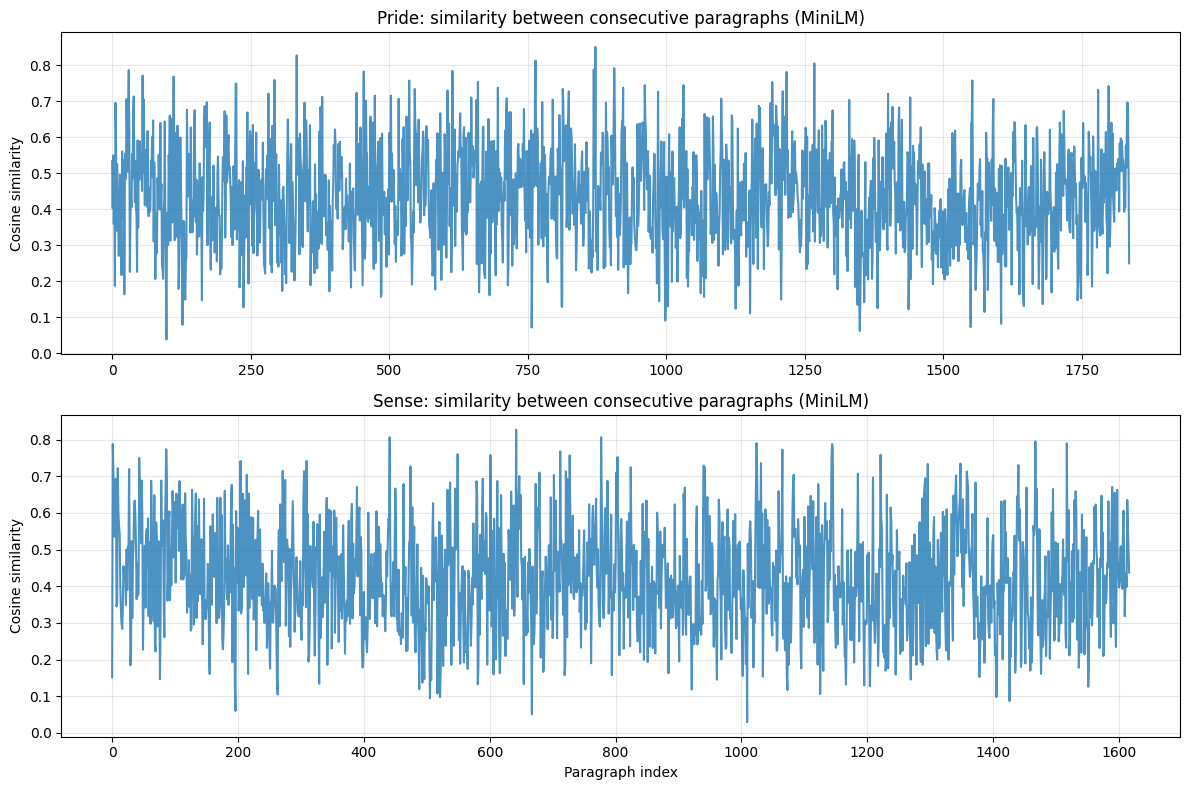

In [5]:
# Visualize topic drift as a line plot (similarity index)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

axes[0].plot(p_drift, alpha=0.8)
axes[0].set_title('Pride: similarity between consecutive paragraphs (MiniLM)')
axes[0].set_ylabel('Cosine similarity')
axes[0].grid(True, alpha=0.3)

axes[1].plot(s_drift, alpha=0.8)
axes[1].set_title('Sense: similarity between consecutive paragraphs (MiniLM)')
axes[1].set_xlabel('Paragraph index')
axes[1].set_ylabel('Cosine similarity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    """Split raw text into paragraphs using blank lines as boundaries.
    Filters out very short paragraphs (e.g. chapter titles)."""
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

def sentence_split(paragraph: str) -> List[str]:
    """Very simple sentence splitter based on punctuation."""
    sentences = re.split(r'[.!?]+\s+', paragraph.strip())
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[list, list]:
    """Compute embedding-based coherence for each paragraph.

    Steps:
    - Split each paragraph into sentences
    - Compute MiniLM embeddings for all sentences
    - Compute the centroid (mean embedding) for the paragraph
    - Coherence = average cosine similarity of each sentence
      to the centroid embedding
    """
    scores = []
    lengths = []
    for p in paragraphs:
        sents = sentence_split(p)
        if len(sents) < 2:
            continue
        # Encode all sentences in this paragraph
        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]
        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))
    return scores, lengths

pride_paras = split_into_paragraphs(pride_text)
sense_paras = split_into_paragraphs(sense_text)

p_scores, p_lengths = paragraph_coherence_embeddings(pride_paras)
s_scores, s_lengths = paragraph_coherence_embeddings(sense_paras)

print(f"Pride and Prejudice (embeddings): {sum(p_scores)/len(p_scores):.3f}")
print(f"Sense and Sensibility (embeddings): {sum(s_scores)/len(s_scores):.3f}")


Pride and Prejudice (embeddings): 0.697
Sense and Sensibility (embeddings): 0.710


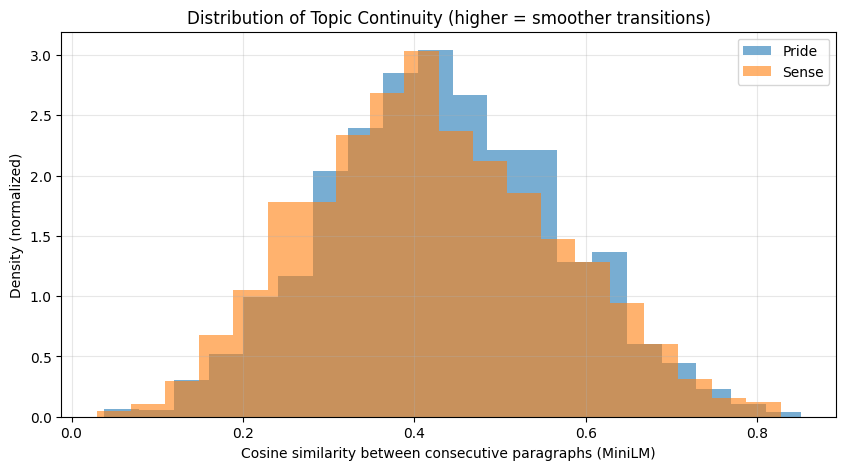

In [6]:
# Histogram comparison
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(p_drift, bins=20, alpha=0.6, label='Pride', density=True)
ax.hist(s_drift, bins=20, alpha=0.6, label='Sense', density=True)
ax.set_xlabel('Cosine similarity between consecutive paragraphs (MiniLM)')
ax.set_ylabel('Density (normalized)')
ax.set_title('Distribution of Topic Continuity (higher = smoother transitions)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [7]:
import gc

# Delete large variables to free memory
del pride_text, sense_text
del pride_paras, sense_paras
del p_drift, s_drift

# Clear matplotlib figures
plt.close('all')

# Unload the model from memory
del model

# Force garbage collection
gc.collect()

print("Memory cleaned! Large variables deleted and garbage collected.")

Memory cleaned! Large variables deleted and garbage collected.
